# Milestone 4: Analysis and Visualisation

In [1]:
import db_utils
import pandas as pd
import warnings  

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',None)
warnings.filterwarnings('ignore')  

In [2]:
df_loan=db_utils.load_data_from_csv('df_loan_backup.csv')

In [3]:
df_loan.shape

(47423, 39)

## Task 1: Current state of the loans

In [4]:
df_loan.loan_status.value_counts()

loan_status
Fully Paid                                             23940
Current                                                16705
Charged Off                                             4719
Does not meet the credit policy. Status:Fully Paid       890
Late (31-120 days)                                       490
Does not meet the credit policy. Status:Charged Off      315
In Grace Period                                          232
Late (16-30 days)                                         87
Default                                                   45
Name: count, dtype: int64

In [5]:
df_loan_current=df_loan[df_loan.loan_status=='Current']

In [6]:
df_loan_current.head(2)

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,employment_length,home_ownership,annual_inc,verification_status,issue_date,loan_status,payment_plan,purpose,dti,delinq_2yrs,earliest_credit_line,inq_last_6mths,open_accounts,total_accounts,out_prncp,out_prncp_inv,total_payment,total_payment_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36,7.49,248.82,A,A4,5,MORTGAGE,46000.0,Not Verified,2021-01-01,Current,n,credit_card,19.54,2,1987-10-01,1,12,27,5529.70,5529.70,2982.51,2982.51,2470.30,512.21,0.0,0.0,0.0,2022-01-01,248.82,2022-01-01,0.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36,6.99,407.52,A,A3,9,RENT,50000.0,Not Verified,2021-01-01,Current,n,credit_card,24.20,0,2001-09-01,0,15,31,9102.83,9102.83,4885.11,4885.11,4097.17,787.94,0.0,0.0,0.0,2022-01-01,407.52,2022-01-01,0.0,1,INDIVIDUAL


In [7]:
columns_to_check=['funded_amount_inv','funded_amount','total_payment','total_payment_inv']

In [8]:
df_pct_paid=pd.DataFrame(columns=['desc','value'])

In [9]:
percentage_of_loan_recovered_inv=round(df_loan_current.total_payment_inv.sum()/ df_loan_current.funded_amount_inv.sum() * 100,2)
print(percentage_of_loan_recovered_inv, "% has been recovered against the investor funding.")
df_pct_paid=df_pct_paid._append({'desc':'inv', 'value': percentage_of_loan_recovered_inv}, ignore_index=True)

73.74 % has been recovered against the investor funding.


In [10]:
percentage_of_loan_recovered=round(df_loan_current.total_payment.sum()/ df_loan_current.funded_amount.sum() *100 ,2)
print(percentage_of_loan_recovered, "% has been recovered against the total amount funded.")
df_pct_paid=df_pct_paid._append({'desc':'total', 'value': percentage_of_loan_recovered}, ignore_index=True)

74.61 % has been recovered against the total amount funded.


In [11]:
df_pct_paid

,desc,value
0,inv,73.74
1,total,74.61


<Axes: xlabel='desc'>

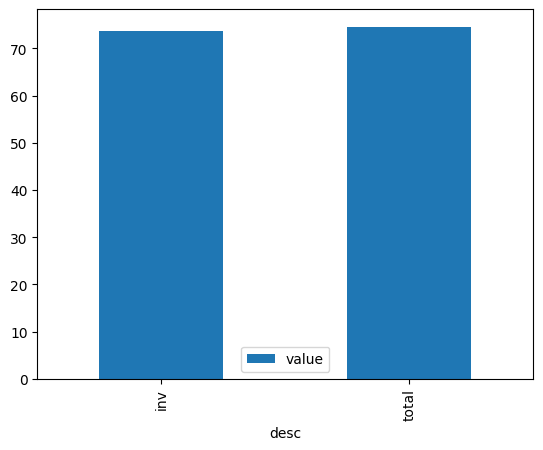

In [12]:
df_pct_paid.plot.bar(x='desc', y='value')

In [13]:
df_loan_current['total_payment_upto_6']=df_loan_current.instalment * 6 + df_loan_current.total_payment

In [14]:
percentage_of_loan_recovered_6=round(df_loan_current.total_payment_upto_6.sum()/ df_loan_current.funded_amount.sum() *100 ,2)
print(percentage_of_loan_recovered_6,"% would be recoevered up to 6 months' in the future.")
df_pct_paid=df_pct_paid._append({'desc':'total_upto_6', 'value': percentage_of_loan_recovered_6}, ignore_index=True)

92.54 % would be recoevered up to 6 months' in the future.


<Axes: xlabel='desc'>

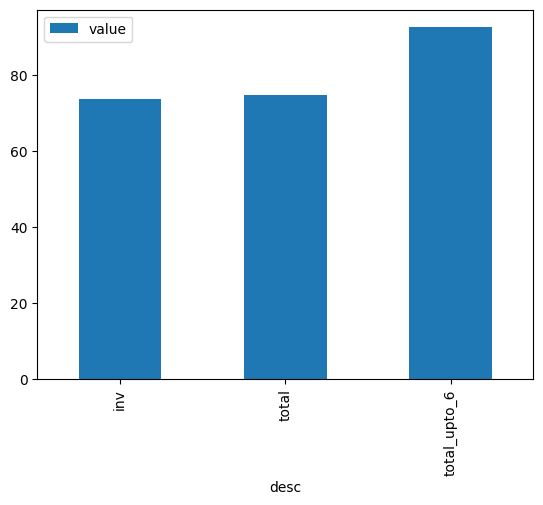

In [15]:
df_pct_paid.plot.bar(x='desc', y='value')

## Task 2: Calculating Loss

In [16]:
df_loan.loan_status.value_counts()

loan_status
Fully Paid                                             23940
Current                                                16705
Charged Off                                             4719
Does not meet the credit policy. Status:Fully Paid       890
Late (31-120 days)                                       490
Does not meet the credit policy. Status:Charged Off      315
In Grace Period                                          232
Late (16-30 days)                                         87
Default                                                   45
Name: count, dtype: int64

In [17]:
pct_of_chargeoff=round(len(df_loan[df_loan.loan_status=='Charged Off'])/len(df_loan)*100,2)
print("Percentage of charged off loans: {} %".format(pct_of_chargeoff))

total_payment_paid_before_chargedoff=round(df_loan[df_loan.loan_status=='Charged Off'].total_payment.sum(),2)
print("Total payment paid before chargedoff: {}".format(total_payment_paid_before_chargedoff))

Percentage of charged off loans: 9.95 %
Total payment paid before chargedoff: 32330240.13


## Task 3: Calculating projected loss 


In [18]:
df_loan_chargedoff=df_loan[df_loan.loan_status=='Charged Off']

In [19]:
df_loan_chargedoff['expected_total_payment']=df_loan_chargedoff.instalment*df_loan_chargedoff.term

In [20]:
loss_amount=df_loan_chargedoff.expected_total_payment.sum() - df_loan_chargedoff.total_payment.sum()
print("The loss in revenue is {}.".format(round(loss_amount,2)))

The loss in revenue is 57536234.31.


In [21]:
# df_loan_chargedoff.expected_total_payment.plot(kind='pie')

pc_loss_amt=pd.DataFrame(columns=['desc','value'])
pc_loss_amt=pc_loss_amt._append({'desc':'payment_received', 'value': df_loan_chargedoff.total_payment.sum() }, ignore_index=True)
pc_loss_amt=pc_loss_amt._append({'desc':'loss', 'value': loss_amount}, ignore_index=True)

<Axes: ylabel='value'>

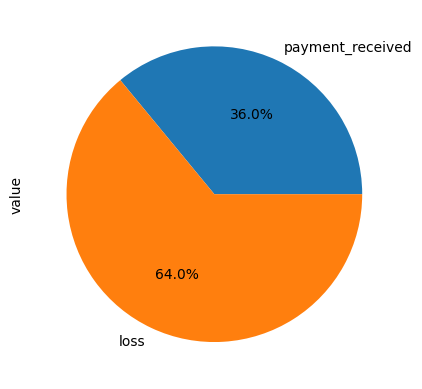

In [22]:
pc_loss_amt.value.plot(kind='pie', autopct='%1.1f%%', labels=pc_loss_amt.desc)

## Task 4: Possible Loss

In [23]:
# df_loan.groupby('loan_status')['funded_amount'].agg('sum')
df_loan.groupby('loan_status')['total_payment'].agg('sum')

loan_status
Charged Off                                            3.233024e+07
Current                                                1.856931e+08
Default                                                4.364734e+05
Does not meet the credit policy. Status:Charged Off    1.646160e+06
Does not meet the credit policy. Status:Fully Paid     9.765066e+06
Fully Paid                                             3.409088e+08
In Grace Period                                        2.869520e+06
Late (16-30 days)                                      8.722510e+05
Late (31-120 days)                                     5.080125e+06
Name: total_payment, dtype: float64

In [24]:
df_loan_late=df_loan[df_loan.loan_status.str.contains('Late')]

In [25]:
print(round(len(set(df_loan_late.member_id))/len(set(df_loan.member_id))*100,2), "% of users are currently behind their loan payments.")

1.22 % of users are currently behind their loan payments.


In [26]:
df_loan_late['expected_total_payment']=df_loan_late.instalment*df_loan_late.term

In [27]:
loss= round(df_loan_late.expected_total_payment.sum() - df_loan_late.total_payment.sum(),2)
print("Projected loss is {}.".format(str(loss)))

Projected loss is 6616434.94.


In [28]:
expected_payments_from_all_chargedoff_and_lateones=df_loan_chargedoff['expected_total_payment'].sum()+df_loan_late.expected_total_payment.sum() 

In [29]:
expected_payments_from_all_chargedoff_and_lateones 

102435285.0

In [30]:
print("% of total expected revenue: ", 
      round(df_loan_late.total_payment.sum()/expected_payments_from_all_chargedoff_and_lateones*100,2))

      

% of total expected revenue:  5.81


Note: I understood here that % calcaulation on ones (those status changed from Late to Chargedoff) against ChargedOff

## Task 5: Indicator of loss

In [175]:
df_t5_chargedoff=df_loan[df_loan.loan_status=='Charged Off'].loc[:, ['loan_status','grade','purpose','home_ownership']].reset_index(drop=True)

In [176]:
df_t5_late=df_loan[df_loan.loan_status.str.contains('Late')].loc[:, ['loan_status','grade','purpose','home_ownership']].reset_index(drop=True)

Text(0.5, 1.0, 'Late home_ownership')

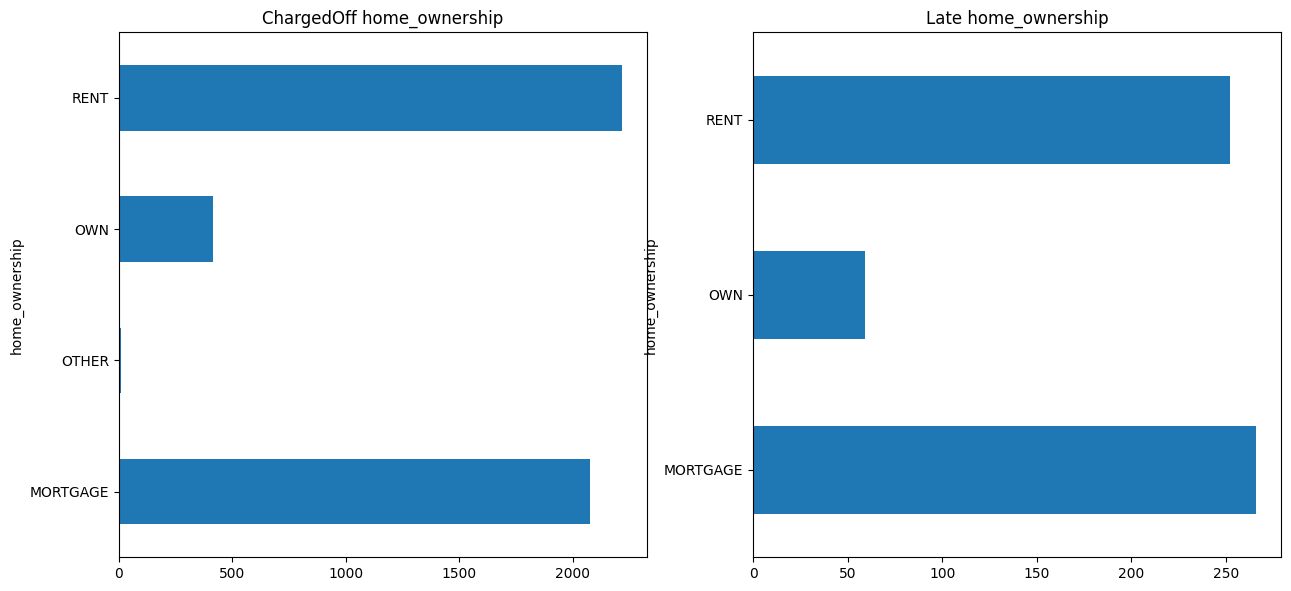

In [177]:
fig=plt.figure(figsize=(15,15))

plt.subplot(2,2,1) 
df_t5_chargedoff.groupby(['home_ownership'])['home_ownership'].agg('count').plot(kind='barh')
plt.title('ChargedOff home_ownership')

plt.subplot(2,2,2)
df_t5_late.groupby(['home_ownership'])['home_ownership'].agg('count').plot(kind='barh')
plt.title('Late home_ownership')


Text(0.5, 1.0, 'Late grade')

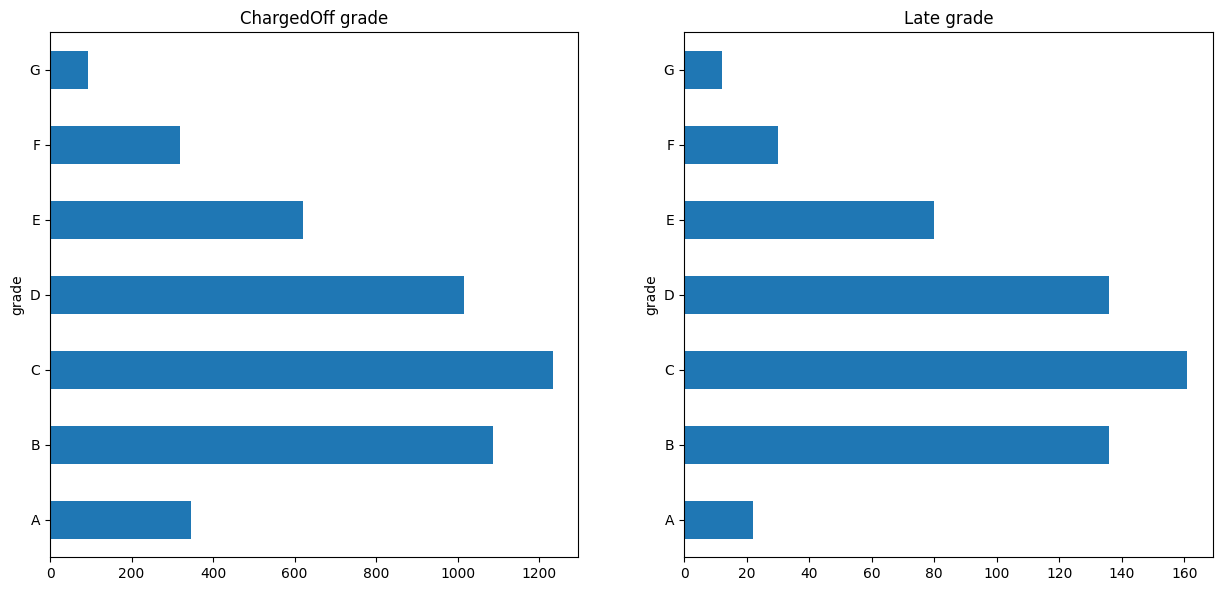

In [178]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
df_t5_chargedoff.groupby(['grade'])['grade'].agg('count').plot(kind='barh')
plt.title('ChargedOff grade')

plt.subplot(2,2,2)
df_t5_late.groupby(['grade'])['grade'].agg('count').plot(kind='barh')
plt.title('Late grade')

Text(0.5, 1.0, 'Late purpose')

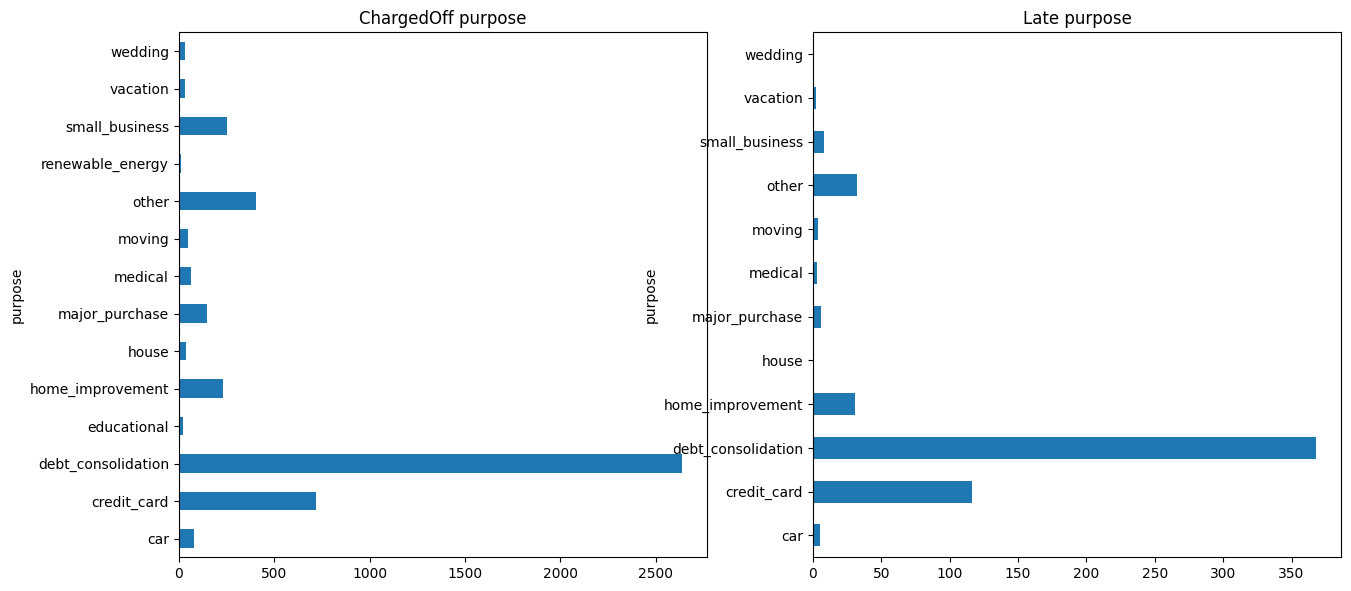

In [179]:
fig=plt.figure(figsize=(15,15))

plt.subplot(2,2,1) 
df_t5_chargedoff.groupby(['purpose'])['purpose'].agg('count').plot(kind='barh')
plt.title('ChargedOff purpose')

plt.subplot(2,2,2)
df_t5_late.groupby(['purpose'])['purpose'].agg('count').plot(kind='barh')
plt.title('Late purpose')

Based on horizontal barplots, grades, home_ownership and purpose columns in both charged off loans and late payments loans.

As these are categorical data, chi2_contengency in scipy.stats will be used. Null hypothesis here is there is no relationship between two categorical variables. Alternate Hypothesis here is there is relationship between two categorical variables.

In [180]:
from scipy.stats import chi2_contingency

In [182]:
print("checking late loans")
for col in ['grade','purpose','home_ownership']:
    print(col)
    chisq=pd.crosstab(df_t5_late['loan_status'], df_t5_late[col])
    res = chi2_contingency(chisq)
    print("p value is", res.pvalue)
    significance_level=0.05
    if res.pvalue >0.05: 
        print("reject H0")
    else:
        print("accept H0")

checking late loans
grade
p value is 0.8137536818404312
reject H0
purpose
p value is 0.39584428956887446
reject H0
home_ownership
p value is 0.1705168484839697
reject H0


Thus, there is a relationship between two categorical variables tested. i.e. loan_status vs grades, loan_status vs home_ownership, and loan_status vs purpose.